###Mount on drive

In [120]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Download related libraries

In [121]:
import nltk
nltk.download('stopwords')

import nltk
nltk.download('punkt')

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [122]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stemmerPorter = PorterStemmer()
stemmerSnow = nltk.SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [123]:
!pip install yellowbrick

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import statistics
from scipy.interpolate import make_interp_spline, BSpline

### Load and explore datasets

In [124]:
train_csv = '/content/gdrive/My Drive/datasets/vaccine_train_set.csv'

test_csv = '/content/gdrive/My Drive/datasets/vaccine_validation_set.csv'

In [125]:
import pandas as pd

df_train = pd.read_csv(train_csv)

df_train.head()

,Unnamed: 0,tweet,label
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,1,I don't know about you but My family and I wil...,1
2,2,@MSignorile Immunizations should be mandatory....,2
3,3,President Obama spoke in favor of vaccination ...,0
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [126]:
df_train.shape

(15976, 3)

In [127]:
df_train = df_train.drop(['Unnamed: 0'], axis=1)

In [128]:
df_test = pd.read_csv(test_csv)

df_test.head()

,Unnamed: 0,tweet,label
0,0,@user They had a massive surge in with covid d...,1
1,1,Required vaccines for school: Parents and guar...,0
2,2,“@KCStar: Two more Johnson County children hav...,0
3,3,NV can do better. Which states are the best (a...,2
4,4,Nothing like killing ourselves w/ our own fear...,2


In [129]:
df_test.shape

(2282, 3)

In [130]:
df_test = df_test.drop(['Unnamed: 0'], axis=1)

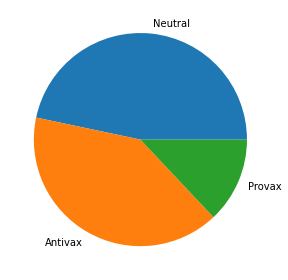

In [131]:
import matplotlib.pyplot as plt

cnt = df_train['label'].value_counts()

fig, ax = plt.subplots()
ax.pie(cnt, labels=['Neutral', 'Antivax', 'Provax'])
# ax.set_title('Cardinality of Values')
plt.tight_layout()

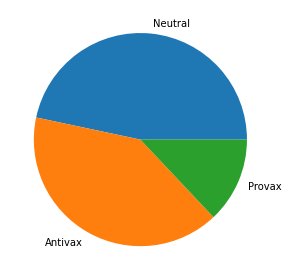

In [132]:
import matplotlib.pyplot as plt

cnt = df_test['label'].value_counts()

fig, ax = plt.subplots()
ax.pie(cnt, labels=['Neutral', 'Antivax', 'Provax'])
# ax.set_title('Cardinality of Values')
plt.tight_layout()

### Data cleaning

In [133]:
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize as wt

stopWords = set(stopwords.words('english'))

In [134]:
def stem(data):
  f_data = []
  for row in range(data.shape[0]):
    merge = data.iloc[row, 2]
    tokenized_text = wt(merge)
    cleaned_text = []
    for word in tokenized_text:
      if word not in stopWords:
        cleaned_text.append(stemmerPorter.stem(word))
    final_text = ' '.join(cleaned_text)
    f_data.append(final_text)
  return data

def data_cleaning(df):
  df['cleaned_tweet'] = df['tweet'].apply(lambda x : re.sub(r'http\S+', ' ', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub(r'https\S+', ' ', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub(r'@\S+', ' ', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub(r'#\S+', ' ', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].str.lower()
  df['cleaned_tweet'] = df['cleaned_tweet'].str.encode('ascii', 'ignore').str.decode('ascii')
  df['cleaned_tweet'] = df['cleaned_tweet'].str.replace('[^\w\s@/:%.,_-]', ' ', flags=re.UNICODE)
  df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'[^\w\s]+', ' ', regex=True)
  df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'<[^>]+>', ' ', regex=True)
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: re.sub(r"@[A-Za-z0-9]+", ' ', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopWords)]))
  df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)
  df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub('<.*?>','', x))
  df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'\d+', ' ', regex=True)
  df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'\s+', ' ', regex=True)
  stem(df)

In [135]:
data_cleaning(df_train)
data_cleaning(df_test)

In [136]:
df_test.tweet[100]

'The only vaccine he should get comes from a vet to put him to sleep https://t.co/Ao6qVFuRVO'

In [137]:
df_test.cleaned_tweet[100]

'vaccine get comes vet put sleep'

In [138]:
from sklearn.model_selection import train_test_split

X_train = df_train['cleaned_tweet']
y_train = df_train['label']

X_test = df_test['cleaned_tweet']
y_test = df_test['label']

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import SparsePCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer


def create_pipeline(vectorizer=TfidfVectorizer(ngram_range=(1,2)), svd = None):
  pip = Pipeline(steps=[
                      ('vectorizer', vectorizer),
                      ('svd', svd),
                      ('logistic', LogisticRegression(multi_class='multinomial', max_iter=10000))
                      ])
  return pip

### Experiments
#### This section performs cross validation over 14 combinations to select the best one. It is therefore, commented out in order to avoid long runs. There is no need for evaluating this section, as every combination is presented on ReadMe alongside with various plots.

In [ ]:
"""
scorer = {'precision': make_scorer(precision_score, average='micro'),
          'recall': make_scorer(recall_score, average='micro'),
          'f1': make_scorer(f1_score, average='micro')}

scores = {'tf-idf + ngram(1,2)': {},
          'tf-idf + ngram(1,3)': {},
          'tf-idf + ngram(1,4)': {},
          'tf-idf + ngram(1,2) + svd + 8 comp': {},
          'tf-idf + ngram(1,2) + svd + 10 comp': {},
          'tf-idf + ngram(1,2) + svd + 3 comp': {},
          'tf-idf': {},
          'count-vec + ngram(1,2)': {},
          'count-vec + ngram(1,3)': {},
          'count-vec + ngram(1,4)': {},
          'count-vec + ngram(1,2) + svd + 8 comp': {},
          'count-vec + ngram(1,2) + svd + 10 comp': {},
          'count-vec + ngram(1,2) + svd + 3 comp': {},
          'count-vec': {},
          }

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
"""

In [ ]:
"""
pipelines = {'tf-idf + ngram(1,2)': create_pipeline(),
             'tf-idf + ngram(1,3)': create_pipeline(TfidfVectorizer(ngram_range=(1,3))),
             'tf-idf + ngram(1,4)': create_pipeline(TfidfVectorizer(ngram_range=(1,4))),
             'tf-idf + ngram(1,2) + svd + 8 comp': create_pipeline(TfidfVectorizer(ngram_range=(1,2)), TruncatedSVD(n_components=8, random_state=42)),
             'tf-idf + ngram(1,2) + svd + 10 comp': create_pipeline(TfidfVectorizer(ngram_range=(1,2)), TruncatedSVD(n_components=10, random_state=42)),
            #  'tf-idf + ngram(1,2) + svd + 3 comp': create_pipeline(TfidfVectorizer(ngram_range=(1,2)), TruncatedSVD(n_components=3, random_state=42)),
             'tf-idf': create_pipeline(TfidfVectorizer()),
             'count-vec + ngram(1,2)': create_pipeline(CountVectorizer(ngram_range=(1,2))),
             'count-vec + ngram(1,3)': create_pipeline(CountVectorizer(ngram_range=(1,3))),
             'count-vec + ngram(1,4)': create_pipeline(CountVectorizer(ngram_range=(1,4))),
             'count-vec + ngram(1,2) + svd + 8 comp': create_pipeline(CountVectorizer(ngram_range=(1,2)), TruncatedSVD(n_components=8, random_state=42)),
             'count-vec + ngram(1,2) + svd + 10 comp': create_pipeline(CountVectorizer(ngram_range=(1,2)), TruncatedSVD(n_components=10, random_state=42)),
            #  'count-vec + ngram(1,2) + svd + 3 comp': create_pipeline(CountVectorizer(ngram_range=(1,2)), TruncatedSVD(n_components=3, random_state=42)),
             'count-vec': create_pipeline(CountVectorizer()),
             }
"""

In [ ]:
"""
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

for model in pipelines:
  pip = pipelines[model]
  cv_scores = cross_validate(pip, X_train, y_train, cv=cv, scoring=scorer)
  scores[model] = cv_scores
"""

In [ ]:
"""
T = np.array(range(0,5))
plot = np.linspace(T.min(), T.max(), 300)

prec = (scores['tf-idf'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='Tf-Idf')

prec = (scores['tf-idf + ngram(1,2)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='Tf-Idf + ngrams(1,2)')

prec = (scores['tf-idf + ngram(1,3)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='Tf-Idf + ngrams(1,3)')

prec = (scores['tf-idf + ngram(1,4)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='Tf-Idf + ngrams(1,4)')

plt.legend(loc='best')
plt.show()
"""

In [ ]:
"""
T = np.array(range(0,5))
plot = np.linspace(T.min(), T.max(), 300)

prec = (scores['tf-idf + ngram(1,2) + svd + 10 comp'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='Tf-Idf(1,2) + SVD(10)')

prec = (scores['tf-idf + ngram(1,2) + svd + 8 comp'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='Tf-Idf(1,2) + SVD(8)')

prec = (scores['tf-idf + ngram(1,2)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='Tf-Idf(1,2)')

plt.legend()
plt.show()
"""

In [ ]:
"""
prec = (scores['count-vec'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec')

prec = (scores['count-vec + ngram(1,2)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec + ngrams(1,2)')

prec = (scores['count-vec + ngram(1,3)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec + ngrams(1,3)')

prec = (scores['count-vec + ngram(1,4)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec + ngrams(1,4)')

plt.legend(loc='best')
plt.show()
"""

In [ ]:
"""
T = np.array(range(0,5))
plot = np.linspace(T.min(), T.max(), 300)

prec = (scores['count-vec + ngram(1,2) + svd + 10 comp'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec(1,2) + SVD(10)')

prec = (scores['count-vec + ngram(1,2) + svd + 8 comp'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec(1,2) + SVD(8)')

prec = (scores['count-vec + ngram(1,2)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec + ngrams(1,2)')

plt.legend()
plt.show()
"""

In [ ]:
"""
prec = (scores['tf-idf + ngram(1,2)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='Tf-Idf(1,2)')

prec = (scores['count-vec + ngram(1,2)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec + ngrams(1,2)')

prec = (scores['count-vec + ngram(1,3)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec + ngrams(1,3)')

prec = (scores['count-vec + ngram(1,4)'])['test_precision']
prec = np.sort(prec)
spl = make_interp_spline(T, prec, k=3)
spl_smooth = spl(plot)
plt.plot(plot, spl_smooth, label='CountVec + ngrams(1,4)')

plt.legend(loc='best')
plt.show()
"""

### Test model on validation set


In [148]:
from sklearn.metrics import f1_score, precision_score, recall_score

model = create_pipeline()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Precision Score: ", precision_score(y_test, y_pred, average='micro'))
print("Recall Score: ", recall_score(y_test, y_pred, average='micro'))
print("F1 Score: ", f1_score(y_test, y_pred, average='micro'))

Precision Score:  0.7296231375985978
Recall Score:  0.7296231375985978
F1 Score:  0.7296231375985978


### Compute and plot learning curves

In [149]:
chunk = df_test.shape[0]

In [150]:
df_val = df_train.sample(n=chunk, random_state=42)
df_tr = df_train.drop(df_val.index)

print(df_tr.shape, df_val.shape)

(13694, 3) (2282, 3)


In [151]:
splits = np.linspace(.1, 1.0, 5)
train_scores = {'precision':[], 'recall':[], 'f1':[]}
test_scores = {'precision':[], 'recall':[], 'f1':[]}

In [152]:
def compute_scores(scores, y_actual, y_pred):
  scores['precision'].append(precision_score(y_actual, y_pred, average='micro'))
  scores['recall'].append(recall_score(y_actual, y_pred, average='micro'))
  scores['f1'].append(f1_score(y_actual, y_pred, average='micro'))

In [153]:
def data_label_split(df):
  return (df['cleaned_tweet'], df['label'])

In [154]:
import numpy as np

X_val, y_val = data_label_split(df_val)
X_test, y_test = data_label_split(df_test)
pip = create_pipeline()
for split in splits:
  # get a chunk of train set
  X = df_tr.sample(frac = split)
  X_train, y_train = data_label_split(X)
  # train model
  pip.fit(X_train, y_train)
  # predict on the rest of the train set
  y_pred = pip.predict(X_val)
  compute_scores(train_scores, y_val, y_pred)
  #predict on validation set
  y_pred = pip.predict(X_test)
  compute_scores(test_scores, y_test, y_pred)


In [155]:
print(train_scores)
print(test_scores)

{'precision': [0.6652059596844873, 0.6910604732690623, 0.708150744960561, 0.7156003505696757, 0.7208588957055214], 'recall': [0.6652059596844873, 0.6910604732690623, 0.708150744960561, 0.7156003505696757, 0.7208588957055214], 'f1': [0.6652059596844873, 0.6910604732690623, 0.708150744960561, 0.7156003505696757, 0.7208588957055214]}
{'precision': [0.6555652936021035, 0.6958808063102542, 0.708150744960561, 0.7195442594215601, 0.7256792287467134], 'recall': [0.6555652936021035, 0.6958808063102542, 0.708150744960561, 0.7195442594215601, 0.7256792287467134], 'f1': [0.6555652936021035, 0.6958808063102542, 0.708150744960561, 0.7195442594215601, 0.7256792287467133]}


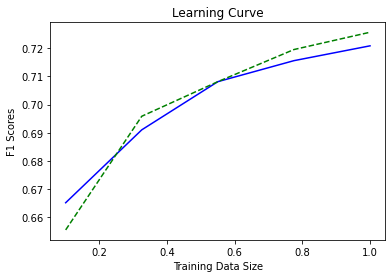

In [156]:
plt.plot(splits, train_scores['f1'], color='blue', markersize=5, label='Train Score')
plt.plot(splits, test_scores['f1'], color='green', markersize=5, linestyle='--', label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('F1 Scores')
# plt.legend(loc='lower right')
plt.show()

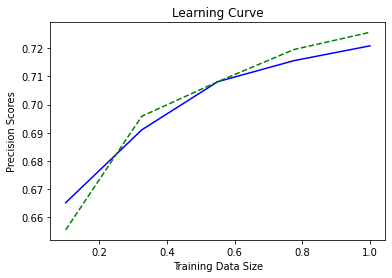

In [157]:
plt.plot(splits, train_scores['precision'], color='blue', markersize=5, label='Train Score')
plt.plot(splits, test_scores['precision'], color='green', markersize=5, linestyle='--', label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Precision Scores')
# plt.legend(loc='lower right')
plt.show()

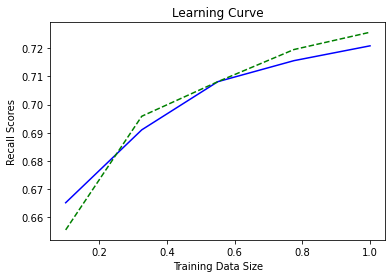

In [158]:
plt.plot(splits, train_scores['recall'], color='blue', markersize=5, label='Train Score')
plt.plot(splits, test_scores['recall'], color='green', markersize=5, linestyle='--', label='Validation Score')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Recall Scores')
# plt.legend(loc='lower right')
plt.show()